# Anomaly Detection using Keras

***

## Introduction

In data analysis, anomalies are defined as events that deviate from the standard, rarely happen, and don’t follow the rest of the “pattern”. [01] Also called outlier detection (and sometimes as novelty detection), anomaly detection is the identification of unexpected events, observations, or items that differ significantly from the norm. Some examples of real world anomalies are:
1. Large dips and spikes in the stock market due to world events.
2. Defective items in a factory/on a conveyor belt.
3. Contaminated samples in a lab.
4. Finding fraudulent login events and fake news items.

To use anomaly detection we must have 2 assumptions: [02]
1. Anomalies in data occur very rarely.
2. The features of data anomalies are significantly different from those of normal data instances.

There are three broad categories of anomaly detection: [03]
1. **Supervised anomaly detection** (technique that requires a data set that has been labeled as "normal" and "abnormal" and involves training a classifier).
2. **Semi-supervised anomaly detection** (technique that assumes that some portion of the data is labelled).
3. **Unsupervised anomaly detection** (technique that assume the data is unlabelled)

**Supervised anomaly detection** is rarely used due to general unavailability of labelled data and the inherent unbalanced nature of the classes. **Semi-supervised anomaly detection**  may be any combination of the normal or anomalous data. Most of the time this method constructs a model representing normal behavior from a given normal training data set, and then tests the likelihood of a test instance to be generated by the model. **Unsupervised anomaly detection** is by far the most commonly used technique due to its wider and relevant application. [03]

![anomaly](https://miro.medium.com/max/828/0*ZfvEQ9aQoUPbFZt2)

## Neural Networks
Neural networks reflect the behavior of the human brain, allowing computer programs to recognize patterns and solve common problems in the fields of AI, machine learning, and deep learning. Artificial neural networks (ANNs) are made up of node layers. Node layers contain an input layer, one or more hidden layers, and an output layer. Each node (artificial neuron),  is connected to another node and has an associated weight and threshold. If the output of any individual node is above the specified threshold value,  then that node is activated and it sends data to the next layer of the network. If it is below the threshold, no data is passed along to the next layer of the network. [10]<br>
The hidden layer is the layer in the hidden network between the input layer (the features) and the output layer (the prediction). Each hidden layer consists of one or more neurons. For example, the following neural network contains two hidden layers, the first with three neurons and the second with two neurons.[08]

![hidden_layer](img/hidden_layer.png)

A neural network is a weighted graph with nodes(neurons), see the below diagram. The lines with weights(w) represent the connections. the inputs come from the outside world and are are denoted by x (x1, x2,...x3). Each of the inputs are multiplied by their respective weights and then they are added. A bias is added if the weighted sum equates to zero, where bias has input as 1 with weight b. Then this weighted sum is passed to the activation function (φ). [11] If the weighted sum equates to zero, then a bias is added to make the output non-zero or something else to scale up to the system's response. Bias has the same input, and weight equals to 1. [12] The activation function limits the amplitude of the output of the neuron. There are various activation functions like the Threshold function, Piecewise linear function, or Sigmoid function. [11]

![neuron](img/neuron.svg)

## Tensorflow

TensorFlow is a mathematical library package designed to create models for machine learning. It is an open-source library. Machine Learing (ML) is similar to the way humans learn. Computers are fed thousands or millions of real-world examples. This creates self-learning models for computers. Software systems can learn and evolve by picking up real-world examples and deriving rules and parameters from them by using ML. This is known as Self-learning, and it is the core of ML and the path to artificial intelligence (computers behaving like humans). [04] TensorFlow is math library that uses dataflow and differentiable programming to perform various tasks focused on training and inference of deep neural networks. developers us it to create machine learning applications using various tools, libraries, and community resources. [05] TensorFlow was designed to work on multiple CPUs or GPUs, as well as mobile operating systems in some circumstances, and it includes wrappers in Python, C++, and Java. [06] <br>
Tensors are the basic data structures in TensorFlow. They represent the connecting edges in a flow diagram called the Data Flow Graph. Tensors are defined as a multidimensional array or list. Tenosrs have three parameters:<br>
1. Rank
2. Shape
3. Type

### Rank
This is the unit of dimensionality of the tensor or the number of dimensions that the tensor has. A tensor's rank is the order or n-dimensions of the tensor.

### Shape
The number of rows and columns of the Tensor.
### Type
The data type assigned to Tensor’s elements. [07]

![tensors](img/tensors.svg)

The way in which TensorFlow works is that it enables the user to build dataflow graphs and structures to define how data moves through a graph by taking inputs as a multi-dimensional array called a Tensor. It then allows the user to construct a flowchart of operations that can be performed on these inputs, which goes in one end and comes the other end as the output. [05]<br>
For example, a neural network tries to classify three penguin species (Chinstrap , Gentoo and Adélie). It classifies penguins based on their body weight, flipper length, and beaks, specifically the length and width measurements of their culmen. When we train the model and feed it an unlabeled example, it yields three predictions: the likelihood that this penguin is the given penguin species. This prediction is called inference. [09]

![hidden_layer](img/penguins.png)

The sum of the output predictions is always 1. The networl predictions are 0.02 for Adelie, 0.95 for Chinstrap, and 0.03 for Gentoo. This means that the model has predicted with 95% certainty that the unlabeled example penguin is a Chinstrap penguin. [09]

### Keras

Keras allows the user to easily build and train neural networks and deep learning models. It is a high-level API. Keras is also one of the most popular Deep Learning frameworks among researchers and developers. It runs on top of Tensorflow or Theano (the "backend"). Keras is a high-performance API. It's easy to create differentiable programs using keras. It is focused on user experience. Keras provides fast prototyping and runs seamlessly on Centaral Processing Units (CPUs) and Graphic Processing Uinits (GPUs). It supports the major companies NVIDeA and AMD. Keras allows for the freedom to design any architecture and is easy to get started with. Keras also provides easy production ways for models. [13][14]

## Timeseries anomaly detection using an Autoencoder

***

We are going to build a script below to demonstrate how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data. To do this, we'll first need a dataset. The dataset that we will use is called the  Numenta Anomaly Benchmark(NAB). It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics. [15]

### Imports

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

# Magic function 
%matplotlib inline

# Change default style sheet
plt.style.use('fivethirtyeight')

## Data

***

NAB is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. [16] NAB includes real-world data with outliers that have known causes. These data files have been collected over years of interacting with customers on resolving their problems related to anomalies. [17] In the data and plots below, there are 2 columns, values (server metrics/clicking rates) and timestamps. You can view the kaggle and github links to the dataset below:

[kaggle - Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab)

[GitHub - numenta/NAB](https://github.com/numenta/NAB)

We will need two datafiles for this project. A csv data file with without the anomaly (`no_anomaly_url`) and a csv data file with the anomaly (`with_anomaly_url`).

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

Next, we need to use pandas to read the `no_anomaly_url` csv file into a DataFrame and set the index column to the 'timestamp'. We will call this variable `df_small_noise`, this is because the resulting plot will have an even spread in terms of peaks and troughs. This same process will also be used on the `with_anomaly_url` and the DataFrame will be called `df_daily_jumpsup`, because there will be a spike in one of the peaks of the waves (the anomaly), hence the name 'jumpsup'.

In [5]:
# Read a comma-separated values (csv) file into DataFrame.
# Use "timestamp" as the row labels of the DataFrame.
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# Return the first n rows (5 by default).
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# Generate descriptive statistics.
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


After using `df_small_noise.head()`, pandas seems to have rounded the first value in the DataFrame. If we look at the first value in the csv file, it's 18.324918539200002. This could be a problem later on so let's investigate this.

In [8]:
# Use iloc for integer-location based indexing. Selection by position.
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# Ask pandas for the 'value' column.
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# Return the 0th value of the DataFrame (does the same thing as above).
df_small_noise.iloc[0].values[0]

18.3249185392

The value seems to be rounded when we print the individual value. It wasn't rounded as much as when we used `df_small_noise.head()`. Below we can multiply by a big number to see if jupyter will display the trailing values.

In [11]:
# Multiply by 10e12 to see if we can see the missing values.
df_small_noise.iloc[0].values[0] * 10e12

183249185392000.0

The missing values are still not being printed. The missing digits are so small however that we probably will not see any effect.

In [12]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_small_noise.shape

(4032, 1)

The DataFrame has 2 dimensions. It has 4032 rows if we do not include the header rows. This matches the raw csv which has 4033 including the header row. Let's now have a look at the plot.

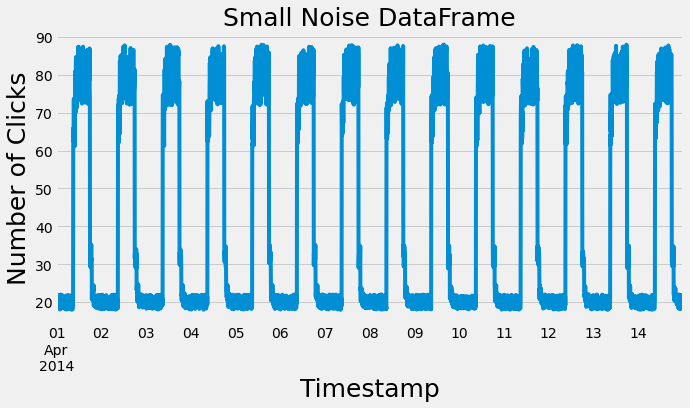

In [13]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,5))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax)
plt.xlabel('Timestamp', fontsize=25)
plt.ylabel('Number of Clicks', fontsize=25)
plt.title('Small Noise DataFrame', fontsize=25);

Now we just need to repeat what we did for the `df_small_noise` on the `df_daily_jumpsup`.

In [14]:
# Read a comma-separated values (csv) file into DataFrame.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [15]:
# Return the first n rows (5 by default).
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [16]:
# Generate descriptive statistics.
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [17]:
# Ask pandas for the 'value' column.
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [18]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_daily_jumpsup.shape

(4032, 1)

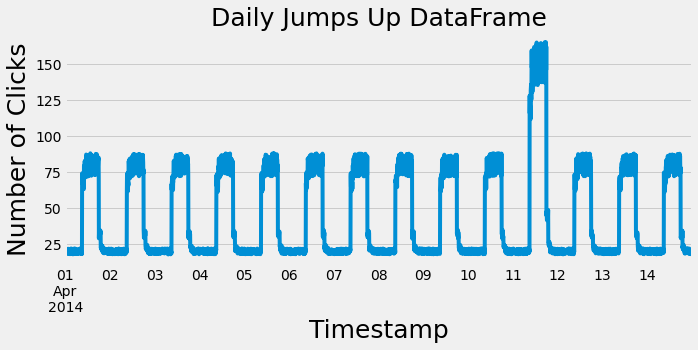

In [19]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.xlabel('Timestamp', fontsize=25)
plt.ylabel('Number of Clicks', fontsize=25)
plt.title('Daily Jumps Up DataFrame', fontsize=25);

## Preprocessing

***

First we need to standardise the values of `df_small_noise` and `df_small_noise` into a new variable called `df_train_vals`. To do this, we first calculate the mean and standard deviation. Then, for each observed value of the variable, we subtract the mean and divide by the standard deviation.

In [20]:
# Get the mean.
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [21]:
# Get the standard deviation.
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

By doing this, we are expressing the values as deviations from the mean in standard deviation units (which are referred to as Z scores). This scales the values down (between -1 and 1.5) by the spread and centres the values around 0. [18]

In [22]:
# Subtract the mean from each value in the DataFrame and divide that value by 
# the standard deviation.
df_train_vals = (df_small_noise - train_mean) / train_std

In [23]:
# Return the first n rows (5 by default).
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [24]:
# Create a new column 'less_mean' which is the result of subtracting 
# the mean from each value in the DataFrame.
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()

# Create a new column 'div_std' which is the result of dividing the 'less_mean' 
# by the standard deviation.
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [25]:
# Take a look at the new columns in 'df_small_noise'
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [26]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.43835333580657, 5.018912974813406e-15, 1.691768418476429e-16)

In [27]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.07712228126252, 28.077122281262515, 0.9999999999999999)

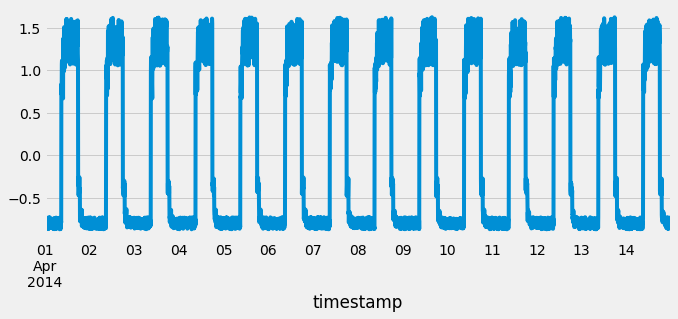

In [28]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

Now, we need to break all of the training values into smaller chunks of small samples (or windows). What sizes are we going to use for the windows? On keras.io, they use window sizes of 288 with the total number of data points being 4032. This is because they want to have a value for every 5 minutes for 14 days. <br>
- 24 * 60 / 5 = 288 timesteps per day
- 288 * 14 = 4032 data points in total [19]

If we look at the shape of `df_train_vals`, we can see that there are 4032 data points.

In [29]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_train_vals.shape

(4032, 1)

We now need to use the Window Sliding technique to train the model. What is Sliding Window? imagine a long chain. Suppose you want to apply oil in the complete chain with your hands, without pouring the oil from above. You could do this by taking a cloth, dipping it in oil, and then holding onto one end of the chain with the cloth. Then, instead of re-dipping it again and again, just slide the cloth with hand onto the next section, and next, and so on until you reach the other end. [20]

![sliding_window](img/sliding_window.jpg)

To do this, we need to create a function (`windows`) that will use the sliding window technique for us. Start with an empty list, loop through all the possible windows, append a window to the list and then stack them all using `numpy.stack` (Join a sequence of arrays along a new axis). The function takes in two parameters, `vals` which will be the training values and `N` which is the window size (288).

In [30]:
# Window size for the DataFrame.
window_size = 288

In [31]:
# Function to generate the windows in the DataFrame.
def windows(vals, N=window_size):
  # For accumulating the windows.
  L = []
  # Generate the windows.
  for i in range(len(vals) - N + 1):
    # append a window to the list.
    L.append(vals[i:i+N])
  # Stack
  return np.stack(L)

In [32]:
# Use def windows to generate the training data for x.
x_train = windows(df_train_vals)

In [33]:
# Look at the first and last values in x_train using indexing.
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [34]:
# Look at the first and last values in x_train using iloc.
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [35]:
# Returns a tuple that shows how many dimension the DataFrame has.
x_train.shape

(3745, 288, 1)

In [36]:
# Ask pandas for the 'value' column and use '.values' to return a Numpy 
# representation of the DataFrame.
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [37]:
# Look at the first element (window) of 'x_train' and use 'flatten' to return 
# a copy of the array collapsed into one dimension.
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

#### Plot of the Training Value Windows

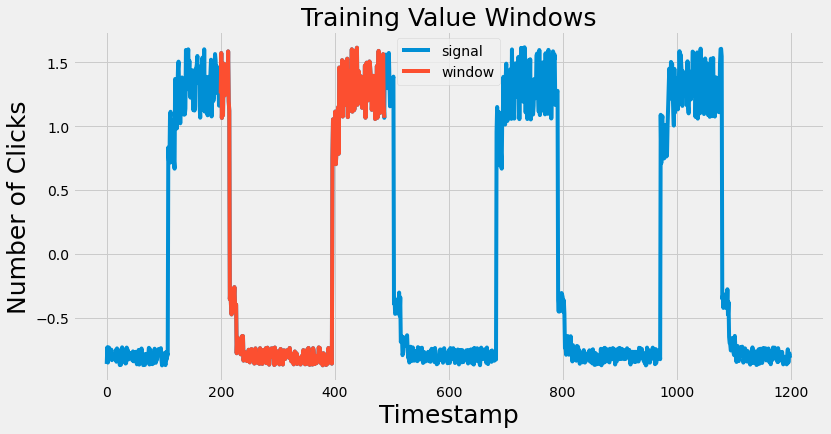

In [38]:
# Change this value to look at different windows.
window_no = 200

# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(12, 6))

# y values are pulled from the 'df_train_vals' DF.
y = df_train_vals['value'].values[:1200]

# We want x values that are spaced out by the same interval as the y values.
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
w = x_train[window_no].flatten()

# plot DataFame.
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

plt.xlabel('Timestamp', fontsize=25)
plt.ylabel('Number of Clicks', fontsize=25)
plt.title('Training Value Windows', fontsize=25);
ax.legend(loc="best");

# Create animation here.

##  Convolutional Neural Networks

In [39]:
x_train.shape

(3745, 288, 1)

Convolutional Neural Networks (CNN or ConvNet) are a class of artificial neural networks (ANN as discussed above), most commonly applied to analyse visual imagery. CNNs provide a scalable approach to image classification and object recognition tasks, leveraging principles from linear algebra, specifically matrix multiplication, to identify patterns within an image. They can be computationally demanding, requiring graphical processing units (GPUs) to train models. They have three main types of layers, which are:
- Convolutional layer
- Pooling layer
- Fully-connected (FC) layer [21]

Let's first define Convolution. Convolution is a mathematical operation on two functions ($f$ and $g$) that produces a third function ($f*g$) that expresses how the shape of one is modified by the other. The term convolution refers to both the result function and to the process of computing it. It is defined as the integral of the product of the two functions after one is reflected about the y-axis and shifted. [22] There are three types of CNNs. 1D, 2D and 3D CNNs (dimensions). Time-Series data such as this type of project uses 1D CNN, also known as **Conv1D**. In Conv1D, the kernel (also known as the filter), which we can think of as the **window** from what we discussed above, slides along one dimension. See the diagram below for an example with a window size of 5 for simplicity.

![convolution](img/convolution.svg)

Each output timestamp is obtained from a temporal patch in the input sequence. 1D convolution layers are translation invariant in the sense that because the same input transformation is performed on every patch, a pattern learned at a certain position can later be recognized at a different position. Similar to The patches can be extracted from an input and output the maximum or average value, a process referred to as Max Pooling and Average Pooling. This is used for reducing the length of the 1D input (technically known as subsampling). [23]

Keras will let us use multidimensional input layers, but generally speaking, we use 1 dimensional input layers. This means that all of the values in the window are going into the neural network as the input in one fell swoop. There are 288 nodes or neurons at the start that are coming in with 288 values, each of which is a value from the input dataset. 

In [40]:
# Using 1 dimensional input layer.
layers = [
  # 288 nodes, 1 dimention.
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # Conv1D layer
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Dropout layer
  keras.layers.Dropout(rate=0.2),
  # Conv1D layer
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Conv1DTranspose layer
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Dropout layer
  keras.layers.Dropout(rate=0.2),
  # Conv1DTranspose layer
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Conv1DTranspose layer
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In the above code, Dropout is used to fix the over-fitting issue. The Input data may have some unwanted data, also known as Noise. Dropout will try to remove the noise data and thus prevent the model from over-fitting. Rate represents the fraction of the input unit to be dropped (0 to 1). [24] The Conv1DTranspose layer function is used to apply the transposed 1D convolution operation, also known as deconvolution, on data.[25]

Next we need to creat the model. We will use the `Sequential` class (Sequential API.) to arrange the layers into a sequential order. We pass the `layers` from above as a parameter. This It allows us to create a deep learning model by adding layers to it. Every unit in a layer is connected to every unit in the previous layer. [26]

In [41]:
# Sequential class.
model = keras.Sequential(layers)

In [42]:
# Adam Optimizer.
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [43]:
# Loss function "mse" Mean Squared Error.
model.compile(optimizer=optimizer, loss="mse")

The adam optimizer (Adaptive Moment Estimation) uses the adam algorithm in which the stochastic gradient descent method is leveraged for performing the optimization process. It is efficient to use and consumes very little memory. It is used in cases where huge amount of data and parameters are available for usage. <br>
Why do we need to Optimizers? First we need to define what an epoch is. An epoch is when all the training data is used at once and is defined as the total number of iterations of all the training data in one cycle for training the machine learning model. [28] When training a neural network, its weights are initially initialized randomly and then they are updated in each epoch to increase the overall accuracy of the network. In each epoch, the output of the training data is compared to the actual data. The loss function (mse loss function) is used to calculate the error and then the weight is updated. Optimization is knowing how to update the weight such that it increases the accuracy where the goal is to optimize the loss function and arrive at ideal weights. Gradient Descent is the most widely known but there are many other optimizers that are used for practical purposes and they all are available in Keras. [27]

![optimisation](img/optimisation.png)

Optimizers help Neural Network to convert on the lowest point on error surface known as minima.

In [44]:
# Look at entire model summary with output shape and number of parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

Now we need to fit the model. We are going to use `x_train` as both the input and the target since this is a reconstruction model. We need to train the data with no anomalies. If the reconstruction error for the new dataset is above a threshold, we label that example/data point as an anomaly. <br>
The callback parameter uses EarlyStopping. This is so we don’t need to hard code the number of epochs. If our network doesn’t improve for 3 consecutive epochs,i.e. validation loss is not decreased we stop the training process. Number of epochs is set to 50. The higher amount of epochs, the more accurate the training. 10 % of the data is held back for validation. [29]

In [45]:
# Fit the model.
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 2s 32ms/step - loss: 0.5550 - val_loss: 0.0796
Epoch 2/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0757 - val_loss: 0.0399
Epoch 3/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0535 - val_loss: 0.0338
Epoch 4/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0451 - val_loss: 0.0283
Epoch 5/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0401 - val_loss: 0.0270
Epoch 6/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0362 - val_loss: 0.0249
Epoch 7/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0329 - val_loss: 0.0221
Epoch 8/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0304 - val_loss: 0.0203
Epoch 9/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0283 - val_loss: 0.0192
Epoch 10/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0264 - val_loss: 0.0187
Epoch 11/

## Evaluation

***

The neural network keeps a histrory of how the fitting procedure went. `val_loss` is the value of cost function for our cross-validation data (the 10% that we held back for validation), and loss is the value of cost function for our training data. [30]

In [46]:
history.history["loss"]

[0.5549634695053101,
 0.0757414922118187,
 0.053493138402700424,
 0.04512917250394821,
 0.04013848304748535,
 0.03620052710175514,
 0.03294925019145012,
 0.030414417386054993,
 0.028261497616767883,
 0.026444097980856895,
 0.024905230849981308,
 0.023692527785897255,
 0.022669559344649315,
 0.0216630008071661,
 0.020883427932858467,
 0.02010837197303772,
 0.019419603049755096,
 0.018680937588214874,
 0.018040427938103676]

In [47]:
history.history["val_loss"]

[0.0796063169836998,
 0.03988271206617355,
 0.03383321687579155,
 0.028313294053077698,
 0.027013758197426796,
 0.02488715574145317,
 0.02211786061525345,
 0.020281333476305008,
 0.01918742060661316,
 0.018744148313999176,
 0.016952799633145332,
 0.017934652045369148,
 0.017173120751976967,
 0.01668447069823742,
 0.01711467280983925,
 0.017345771193504333,
 0.017984436824917793,
 0.017924217507243156,
 0.017207110300660133]

Let's plot the Training loss against the validation loss below.

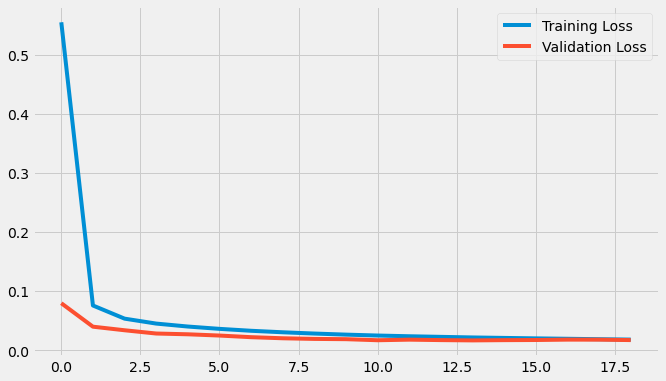

In [48]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
# Training Loss
ax.plot(history.history["loss"], label="Training Loss")
# Validation Loss
ax.plot(history.history["val_loss"], label="Validation Loss")
# Legend
ax.legend();

In [49]:
# Get train MAE (Mean Absolute Error) loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 0s 3ms/step


In [50]:
# Calculate loss.
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

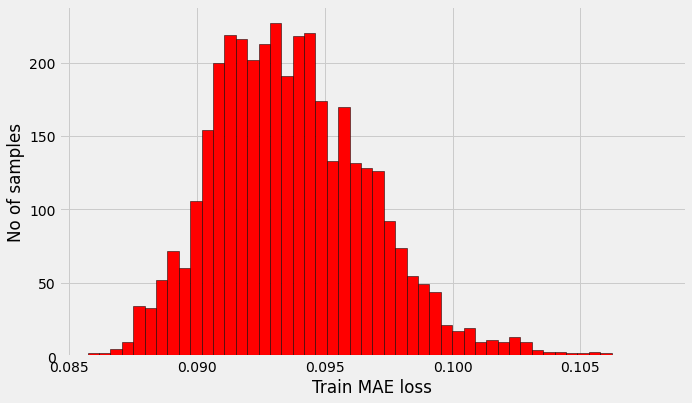

In [51]:
# Plotting.
fig, ax = plt.subplots(figsize=(10, 6))
# See if the predictions are any good.
ax.hist(train_mae_loss, bins=50, edgecolor='black', color='r')
# x label.
ax.set_xlabel("Train MAE loss")
# y label.
ax.set_ylabel("No of samples");

In the above histogram, the further on the x-axis that the sample is, the worse it did in trying to reconstruct a sample. The very worst sample got a loss score of 0.11602140332575497 (of course this will change every time the notebook is re-run). So, we can say that when the neural network tries to predict the data points, if it goes over 0.11602140332575497 which is the threshold, then we can infer that the model is seeing a pattern that it isn't familiar with and we will label this sample as an anomaly. [15]

In [52]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Look at threshold.
threshold

0.10801101905242814

Let's plot the training set against what the neural network is predicting the output should be.

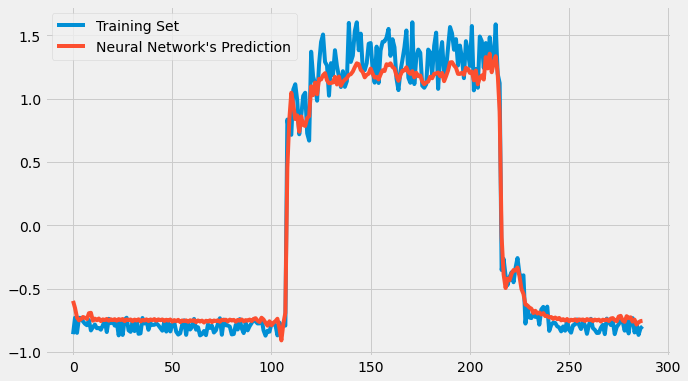

In [53]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Training set.
ax.plot(x_train[0], label="Training Set")

# What the neural network is predicting the output should be.
ax.plot(x_train_pred[0], label="Neural Network's Prediction")
ax.legend();

Next, we need to standardise the values of `df_daily_jumpsup` just like we did above for the `df_train_vals`. We just need to follow the same steps as when we trained the model on the test model.

In [54]:
# Subtract training mean from df_daily_jumpsup.
df_test_value = (df_daily_jumpsup - train_mean) / train_std

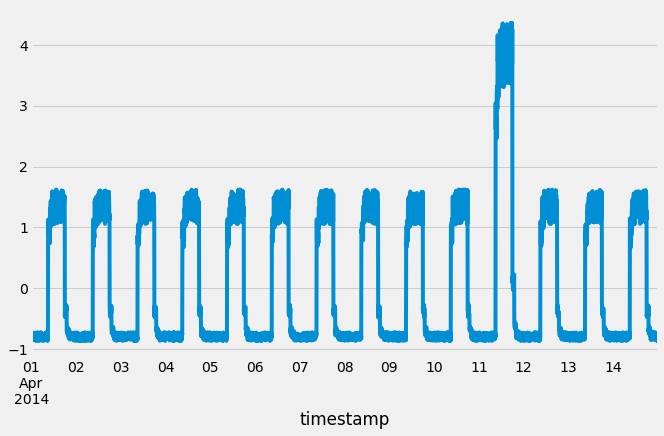

In [55]:
# Plotting.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the test values.
df_test_value.plot(legend=False, ax=ax);

Use the windows function just like we did before witht the training data.

In [56]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [57]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 3ms/step


In [58]:
# Test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

In [59]:
# Re-shape the data.
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.09132231, 0.09315404, 0.09426835, ..., 0.09281913, 0.0915019 ,
       0.09102215])

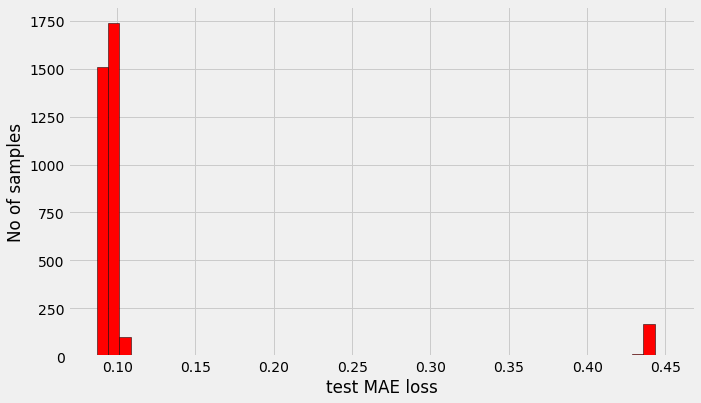

In [60]:
# Plotting.
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram.
ax.hist(test_mae_loss, bins=50, edgecolor='black', color='r')

# x label test MAE loss.
ax.set_xlabel("test MAE loss")

# y label No of samples.
ax.set_ylabel("No of samples");

We can see here that this histogram looks a lot different to the previous one. This is because the values on the left are all within the threshold. The highest value for number of samples in the previous was 300, so that is why all of the values that are within the threshold are bunched together on the left of the histogram. The values on the right hand side did really badly according to the model that we created. In other words, they are way above the threshold that we previously created and therefore we can that that they are anomalies. Below we calcualte the number of anomalies.

In [61]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

397

Since we know which samples of data are anomalies, we can find the corresponding timestamps from the original test data. The below code is used to do this.

In [62]:
# Data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [63]:
# Gets the subset of df_daily_jumpsup where there are anomalies.
df_subset = df_daily_jumpsup.iloc[inds]

Let's overlay the anomalies on the original test data plot. The red points are the anomalies.

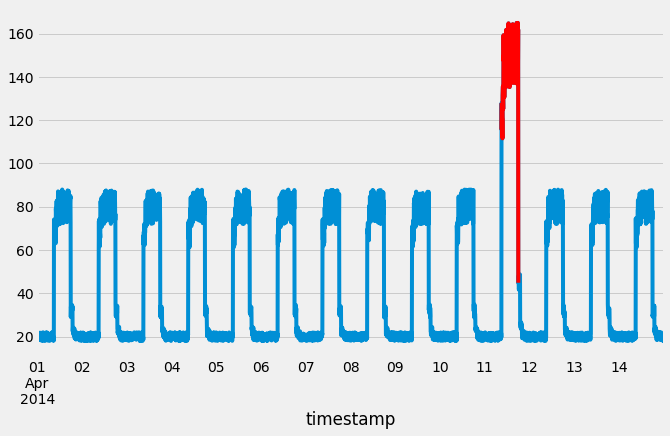

In [64]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
df_daily_jumpsup.plot(legend=False, ax=ax)

# Plot anamolies in red.
df_subset.plot(legend=False, ax=ax, color="r");

***

## References

***

[01] [pyimagesearch.com - Intro to anomaly detection with OpenCV, Computer Vision, and scikit-learn](https://pyimagesearch.com/2020/01/20/intro-to-anomaly-detection-with-opencv-computer-vision-and-scikit-learn/)<br>
[02] [avinetworks.com - Anomaly Detection](https://avinetworks.com/glossary/anomaly-detection/)<br>
[03] [wikipedia.org - Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection)<br>
[04] [askpython.com - Python TensorFlow – A Beginner’s Introduction](https://www.askpython.com/python-modules/python-tensorflow-introduction)<br>
[05] [guru99.com - What is TensorFlow? How it Works? Introduction & Architecture](https://www.guru99.com/what-is-tensorflow.html#1)<br>
[06] [towardsai.net - What is TensorFlow, and how does it work?](https://towardsai.net/p/l/what-is-tensorflow-and-how-does-it-work)<br>
[07] [tutorialspoint.com - TensorFlow - Basics](https://www.tutorialspoint.com/tensorflow/tensorflow_basics.htm)<br>
[08] [developers.google.com - Machine Learning Glossary](https://developers.google.com/machine-learning/glossary/#hidden_layer)<br>
[09] [tensorflow.org - Custom training: walkthrough](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough)<br>
[10] [ibm.com - Neural Networks](https://www.ibm.com/in-en/cloud/learn/neural-networks)<br>
[11] [educba.com - What is Neural Networks](https://www.educba.com/what-is-neural-networks/)<br>
[12] [javatpoint.com - Artificial Neural Network Tutorial](https://www.javatpoint.com/artificial-neural-network)<br>
[13] [askpython.com - Keras Deep Learning in Python](https://www.askpython.com/python/examples/keras-deep-learning)<br>
[14] [guru99.com - Keras Tutorial: What is Keras? How to Install in Python](https://www.guru99.com/keras-tutorial.html)<br>
[15] [keras.io - Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)<br>
[16] [kaggle.com - Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab)<br>
[17] [medium.com - Everything You Need to Know About Numenta Anomaly Benchmark (NAB)](https://fintelics.medium.com/everything-you-need-to-know-about-numenta-anomaly-benchmark-nab-b43ab7f014df)<br>
[18] [sage-advices.com - What does subtracting mean and dividing by standard deviation do?](https://sage-advices.com/what-does-subtracting-mean-and-dividing-by-standard-deviation-do/)<br>
[19] [keras.io - Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)<br>
[20] [geeksforgeeks.org - Window Sliding Technique](https://www.geeksforgeeks.org/window-sliding-technique/)<br>
[21] [ibm.com - What are convolutional neural networks?](https://www.ibm.com/topics/convolutional-neural-networks)<br>
[22] [wikipedia.org - Convolution](https://en.wikipedia.org/wiki/Convolution)<br>
[23] [medium.com - Sentiment Analysis using 1D Convolutional Neural Networks in Keras](https://learnremote.medium.com/sentiment-analysis-using-1d-convolutional-neural-networks-part-1-f8b6316489a2)<br>
[24] [tutorialspoint.com - Keras - Dropout Layers](https://www.tutorialspoint.com/keras/keras_dropout_layers.htm)<br>
[25] [geeksforgeeks.org - Python Tensorflow – tf.keras.layers.Conv1DTranspose() Function](https://www.geeksforgeeks.org/python-tensorflow-tf-keras-layers-conv1dtranspose-function/)<br>
[26] [codespeedy.com - The Sequential model in Keras in Python](https://www.codespeedy.com/the-sequential-model-in-keras-in-python/)<br>
[27] [machinelearningknowledge.ai - Keras Optimizers Explained with Examples for Beginners](https://machinelearningknowledge.ai/keras-optimizers-explained-with-examples-for-beginners/#3_Keras_Adam_Optimizer_Adaptive_Moment_Estimation)<br>
[28] [simplilearn.com - What is Epoch in Machine Learning?](https://www.simplilearn.com/tutorials/machine-learning-tutorial/what-is-epoch-in-machine-learning#what_is_epoch)<br>
[29] [medium.com - Anomaly Detection in Time Series Data Using Keras](https://medium.com/swlh/anomaly-detection-in-time-series-data-using-keras-60763157cecc)<br>
[30] [datascience.stackexchange.com - Keras difference beetween val_loss and loss during training](https://datascience.stackexchange.com/questions/25267/keras-difference-beetween-val-loss-and-loss-during-training)<br>